### Get scale limit for a mobile re-captured image
1. Zoom in initial scale.
2. Crop image w/ current scale.
3. Execute FFT & calculate wave length of the cropped image.
4. Get pixel width in x-y axes.
5. Optimize scale to obtain 10-pixel width and 10-pixel height (iterate Step 2 to 4).

Reading image to align :  snipping\source.png


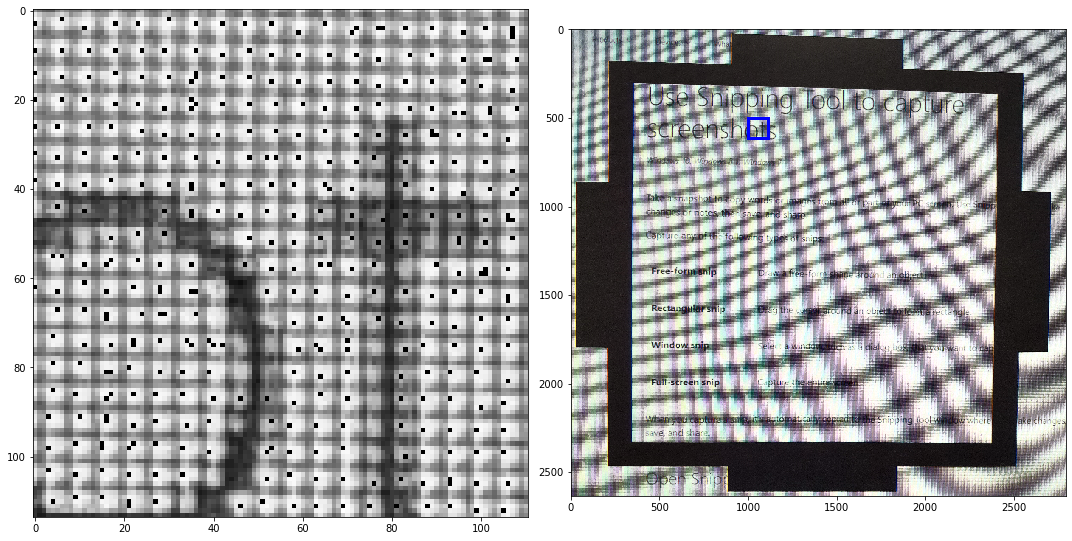

In [4]:
from pre_process import *
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.feature import peak_local_max

dirName = "snipping"
imFilename = os.path.join(dirName, "source.png")

print("Reading image to align : ", imFilename);  
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

pim = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
n_pixel = 20

height, width = pim.shape
        
coordinates = np.array(peak_local_max(pim, min_distance=3))
N = coordinates.shape[0]

d = np.sqrt(width*height/N)
    
nx, ny = tuple(np.array([width, height]) // int(d * n_pixel))

height, width = pim.shape

y_off, x_off = (500, 1000)
h, w = (height//ny, width//nx)
rect = patches.Rectangle((x_off, y_off), w, h, linewidth=3, edgecolor='b', facecolor='none')

_, axes = plt.subplots(ncols=2, figsize=(15,15))
for y, x in coordinates:
    pim[y, x] = 0
axes[0].imshow(pim[y_off:y_off+h, x_off:x_off+w], 'gray')
axes[1].imshow(im)
axes[1].add_patch(rect)
plt.tight_layout()
plt.savefig('pixel_monitor_to_camera.pdf', bbox_inches='tight', pad_inches=0, dpi=300)

### Peak coordinates

In [2]:
coordinates

array([[2632, 2782],
       [2632, 2415],
       [2632, 2393],
       ...,
       [   3,  216],
       [   3,  215],
       [   3,   24]], dtype=int64)

#### Camera pixel size per Monitor pixel

In [3]:
d

5.571272767207455

### Dominant

In [46]:
from sklearn.cluster import KMeans

def dominantColors(img, n_clusters=3):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
    #reshaping to a list of pixels
    img = img.reshape((img.shape[0] * img.shape[1], 3))

    #using k-means to cluster pixels
    kmeans = KMeans(n_clusters, max_iter=1)
    kmeans.fit(img)

    #the cluster centers are our dominant colors.
    return kmeans.cluster_centers_

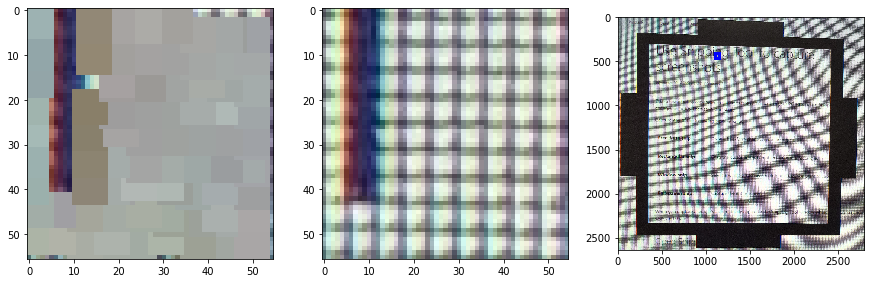

In [47]:
z = int(d//2 + 2)

n_pixel = 10
nx, ny = tuple(np.array([width, height]) // int(d * n_pixel))
y_off, x_off = (400, 1100)
h, w = (height//ny, width//nx)

im2 = im.copy()
for y, x in coordinates:
    if not (y_off < y < y_off+h and x_off < x < x_off+w): continue
    im2[y-z:y+z, x-z:x+z] = dominantColors(im[y-z:y+z, x-z:x+z], 1)[0]
    
rect = patches.Rectangle((x_off, y_off), w, h, linewidth=3, edgecolor='b', facecolor='none')

_, axes = plt.subplots(ncols=3, figsize=(15,15))
axes[0].imshow(im2[y_off:y_off+h, x_off:x_off+w])
axes[1].imshow(im[y_off:y_off+h, x_off:x_off+w])
axes[-1].imshow(im2)
axes[-1].add_patch(rect)
plt.show()

### Probe

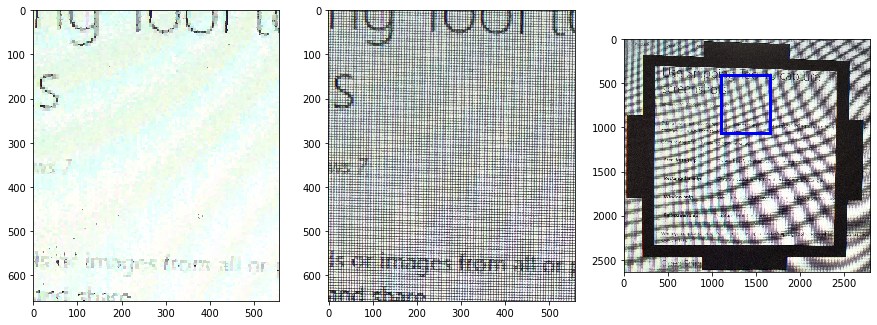

In [48]:
n_pixel = 100
nx, ny = tuple(np.array([width, height]) // int(d * n_pixel))
y_off, x_off = (400, 1100)
h, w = (height//ny, width//nx)

z = int(d/1.2)

im2 = im.copy()
for y, x in coordinates:
#     if 100 < pim[y, x] < 150: continue
    im2[y-z:y+z, x-z:x+z] = im[y, x]
rect = patches.Rectangle((x_off, y_off), w, h, linewidth=3, edgecolor='b', facecolor='none')

_, axes = plt.subplots(ncols=3, figsize=(15,15))
axes[1].imshow(im[y_off:y_off+h, x_off:x_off+w])
axes[0].imshow(im2[y_off:y_off+h, x_off:x_off+w])
# axes[0].imshow(pim2, 'gray')
axes[-1].imshow(im)
axes[-1].add_patch(rect)
plt.show()

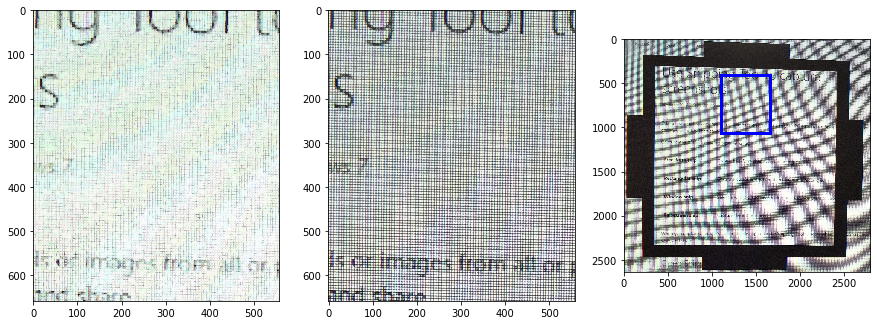

In [49]:
n_pixel = 100
nx, ny = tuple(np.array([width, height]) // int(d * n_pixel))
y_off, x_off = (400, 1100)
h, w = (height//ny, width//nx)

z = int(d/1.2)
im2 = im.copy().astype(np.uint32)

for y, x in coordinates:
    im2[y-z:y+z, x-z:x+z] = (im2[y-z:y+z, x-z:x+z] + im[y, x]) / 2
rect = patches.Rectangle((x_off, y_off), w, h, linewidth=3, edgecolor='b', facecolor='none')

_, axes = plt.subplots(ncols=3, figsize=(15,15))
axes[1].imshow(im[y_off:y_off+h, x_off:x_off+w])
axes[0].imshow(im2[y_off:y_off+h, x_off:x_off+w])
axes[-1].imshow(im)
axes[-1].add_patch(rect)
plt.show()

### Reflect Padding

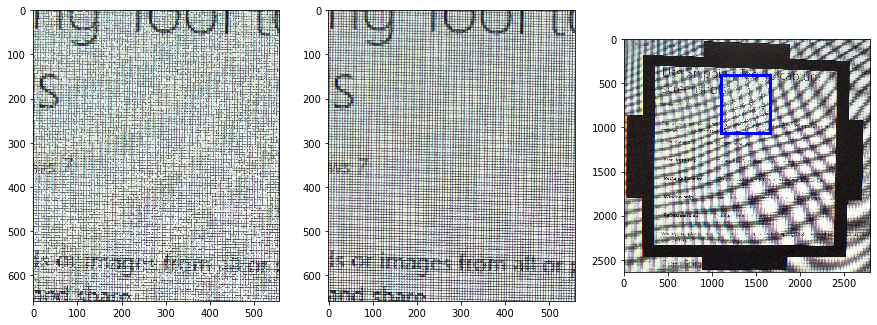

In [50]:
z = int(d*0.5)

n_pixel = 100
nx, ny = tuple(np.array([width, height]) // int(d * n_pixel))
y_off, x_off = (400, 1100)
h, w = (height//ny, width//nx)

im2 = im.copy()
for y, x in coordinates:
    if not (y_off < y < y_off+h and x_off < x < x_off+w): continue
    z_out = z // 2
    z_in = z - z_out
    pad_im = np.pad( im[y-z_in:y+z_in, x-z_in:x+z_in], pad_width=((z_out,z_out),(z_out,z_out),(0,0)), mode='median')
    im2[y-z:y+z, x-z:x+z] = pad_im
    
rect = patches.Rectangle((x_off, y_off), w, h, linewidth=3, edgecolor='b', facecolor='none')

_, axes = plt.subplots(ncols=3, figsize=(15,15))
axes[0].imshow(im2[y_off:y_off+h, x_off:x_off+w])
axes[1].imshow(im[y_off:y_off+h, x_off:x_off+w])
axes[-1].imshow(im2)
axes[-1].add_patch(rect)
plt.show()